In [495]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import os
import sys
from sklearn.model_selection import train_test_split
import warnings

 
os.chdir(sys.path[0] + "\\..")
os.getcwd()

from pysrc import utils 


In [566]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming X is your feature matrix
scaler = StandardScaler()
# pca = PCA(n_components=0.999)  # Retain 95% of the variance


In [567]:
data = pd.read_csv("featured_price.csv")

# Convert 'date' column to datetime if not already
data['date'] = pd.to_datetime(data['date'])

sector_list = data['sector'].drop_duplicates().to_list()
ignored_sector_list = ["央视50_","AH股","分拆预期","破净股","证金持股","上证50_","HS300_","上证180_","中证500","深成500","深证100R","标准普尔","昨日连板_含一字","昨日连板","昨日涨停_含一字","昨日涨停"]

# Sort the data by 'sector' and 'date'
data.sort_values(by=['date','sector'], inplace=True)
data = data[~data['sector'].isin(ignored_sector_list)]
data = data[data['stockCount']<30]
data['log_return'] = data['log_return'].apply(lambda x: 1 if x > 0.08 else (-1 if x < -0.08 else 0))
data[data['log_return']==1]

cols = data.columns.to_list()
index = ['date','sector']
target = ['log_return']
features = [col for col in cols if col not in ['log_return','date','sector']]
# features = new_features

In [568]:
utils.summary(data[features].reset_index())

data shape: (20792, 71)


data type  #missing  %missing  #unique           min  \
index                int64         0       0.0    20792  1.840000e+02   
count              float64         0       0.0     1342  0.000000e+00   
emRatingValue      float64         0       0.0    19315  0.000000e+00   
open               float64         0       0.0    20695  4.116917e+00   
close              float64         0       0.0    20699  4.095194e+00   
...                    ...       ...       ...      ...           ...   
turnover_ma_3      float64         0       0.0    20792  1.249573e+09   
outstanding_ma_3   float64         0       0.0    20792  5.536549e+04   
high_ma_3          float64         0       0.0    20662  4.443333e+00   
low_ma_3           float64         0       0.0    20630  4.010694e+00   
stockCount_ma_3    float64         0       0.0       29  1.000000e+00   

                           max   first value  second value   third value  
index             4.544300e+04  1.840000e+02  2.760000e+02  4.600000e+02  
count             1.475000e+01  6.142857e+00  2.333333e+00  2.214286e+00  
emRatingValue     1.490108e+01  1.729809e+00  4.410846e-01  6.691626e-01  
open              2.125572e+02  3.443100e+01  1.557700e+01  1.616811e+01  
close             2.113137e+02  3.476540e+01  1.559070e+01  1.614044e+01  
...                        ...           ...           ...           ...  
turnover_ma_3     3.531949e+11  3.798895e+10  2.988873e+10  3.606704e+10  
outstanding_ma_3  4.111375e+08  7.247501e+06  4.107138e+07  2.583260e+07  
high_ma_3         2.184283e+02  3.738033e+01  1.763433e+01  1.658064e+01  
low_ma_3          2.038123e+02  3.393067e+01  1.426618e+01  1.529889e+01  
stockCount_ma_3   2.900000e+01  7.000000e+00  1.200000e+01  1.400000e+01  

[71 rows x 9 columns]

In [569]:
date_list = data['date'].drop_duplicates()

X = data[features+index]
y = data[target+index]


# Split data into train and validation sets (80-20 split)
split = int(len(date_list) * 0.8)
X_train, X_val = X[X['date'].isin(date_list[:split])].set_index(['date','sector']), X[X['date'].isin(date_list[split:])].set_index(['date','sector'])
y_train, y_val = y[y['date'].isin(date_list[:split])].set_index(['date','sector']), y[y['date'].isin(date_list[split:])].set_index(['date','sector'])

X_train, X_val = scaler.fit_transform(X_train), scaler.transform(X_val)
# y_train1, y_val1 = y_train.values.ravel(), y_val.values.ravel()

# Initialize XGBoost model
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05)
warnings.simplefilter(action='ignore', category=FutureWarning)


# Train the model
model.fit(X_train, y_train)

# Predict on validation data
y_pred = model.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

rmse

0.13872695004117927

In [570]:
y_pred.mean()+7*y_pred.std()

0.45775336865335703

In [571]:
y_pred

array([ 0.00641822, -0.00455763, -0.01080172, ..., -0.00308857,
       -0.00049618, -0.04376303], dtype=float32)

In [576]:
y_val['y_pred'] = np.where(y_pred > y_pred.mean()+6*y_pred.std(), 1, np.where(y_pred < y_pred.mean()-6*y_pred.std(), -1, 0))
y_val[y_val['y_pred']==1].sort_values("log_return")

log_return  y_pred
date       sector                    
2023-07-28 时空大数据            0       1
2023-05-19 减速器              1       1
2023-06-16 减速器              1       1
2023-08-11 宁夏板块             1       1

In [575]:
pd.crosstab(y_val['log_return'], y_val['y_pred'])

y_pred      -1     0   1
log_return              
-1           0    29   0
 0           3  4218   0
 1           0    42   2

In [548]:
y_val['correct'] = y_val['log_return']==y_val['y_pred']
y_val[(y_val['correct'])&(y_val['y_pred']!=0)]
y_val[y_val['y_pred']!=0]

log_return  y_pred  correct
date       sector                              
2023-03-31 PLC概念             0       1    False
           减肥药               0      -1    False
           第四代半导体            0       1    False
2023-04-07 DRG-DIP           0       1    False
           VPN               0       1    False
...                        ...     ...      ...
2023-08-11 减速器               0       1    False
           宁夏板块              1       1     True
           电子后视镜             0      -1    False
           贵州板块              0      -1    False
           超导概念              0       1    False

[105 rows x 3 columns]

In [549]:
importances = model.feature_importances_
# Create a DataFrame to hold feature names and importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df[importance_df['Importance']>1e-2].sort_values("Importance",ascending=False)

new_features = importance_df['Feature'][:10].to_list() + [col for col in cols if "count" in col or "emRating" in col]
new_features = importance_df[importance_df['Feature'].isin(new_features)]['Feature'][:15].to_list()
new_features

['open_diff_1',
 'high',
 'low_lag_1',
 'close_lag_1',
 'high_diff_1',
 'low_diff_1',
 'low_diff_3',
 'count_diff_3',
 'count_lag_1',
 'close_diff_1',
 'count_diff_1',
 'count_lag_3',
 'emRatingValue_diff_3']

In [550]:
importance_df

Feature  Importance
3            open_diff_1    0.086967
5                   high    0.086642
8              low_lag_1    0.077426
2            close_lag_1    0.076771
7            high_diff_1    0.075427
6             low_diff_1    0.075131
4             low_diff_3    0.073879
10          count_diff_3    0.059093
12           count_lag_1    0.058328
1           close_diff_1    0.058111
11          count_diff_1    0.057696
9        turnover_diff_3    0.057341
14           count_lag_3    0.054715
0                    low    0.051566
13  emRatingValue_diff_3    0.050909

### Rolling

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

In [24]:
# Assuming you have a DataFrame named 'data' with your features and target
# 'log_return' is your target variable, features are the engineered features

# Convert 'date' column to datetime if not already
data['date'] = pd.to_datetime(data['date'])

# Sort the data by 'sector' and 'date'
data.sort_values(by=['sector', 'date'], inplace=True)

# Define features and target
features = ['open_lag_1', 'close_lag_1', 'volume_lag_1', 'turnover_lag_1', 'outstanding_lag_1', 'high_lag_1', 'low_lag_1', 
            'open_ma_5', 'close_ma_5', 'volume_ma_5', 'turnover_ma_5', 'outstanding_ma_5', 'high_ma_5', 'low_ma_5', 
            'price_change', 'log_return_lag_1', 'return_vs_lag', 'return_vs_ma_5', 'return_vs_ma_10']

target = 'log_return'

# Initialize an array to store evaluation results
eval_results = []

# Group data by sector
grouped = data.groupby('sector')

# Loop through each sector
for sector, sector_data in grouped:
    X = sector_data[features]
    y = sector_data[target]
    
    # Initialize XGBoost model
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    
    # Initialize an array to store fold results
    fold_results = []
    
    # Perform rolling time series cross-validation
    for i in range(1, len(X) - 1):
        X_train, X_val = X[:i], X[i:i+1]
        y_train, y_val = y[:i], y[i:i+1]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on validation data
        y_pred = model.predict(X_val)
        
        # Evaluate the model
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        fold_results.append(rmse)
    
    eval_results.append((sector, fold_results))


C:\Users\wangt\AppData\Local\Temp\ipykernel_7656\2669294090.py:41: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train, y_val = y[:i], y[i:i+1]
C:\Users\wangt\AppData\Local\Temp\ipykernel_7656\2669294090.py:41: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train, y_val = y[:i], y[i:i+1]
C:\Users\wangt\AppData\Local\Temp\ipykernel_7656\2669294090.py:41: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be tre

Sector 2025规划, Fold 1: RMSE = 0.0162
Sector 2025规划, Fold 2: RMSE = 0.0145
Sector 2025规划, Fold 3: RMSE = 0.0427
Sector 2025规划, Fold 4: RMSE = 0.0176
Sector 2025规划, Fold 5: RMSE = 0.0359
Sector 2025规划, Fold 6: RMSE = 0.0079
Sector 2025规划, Fold 7: RMSE = 0.0058
Sector 2025规划, Fold 8: RMSE = 0.0264
Sector 2025规划, Fold 9: RMSE = 0.0061
Sector 2025规划, Fold 10: RMSE = 0.0582
Sector 2025规划, Fold 11: RMSE = 0.0696
Sector 2025规划, Fold 12: RMSE = 0.0105
Sector 2025规划, Fold 13: RMSE = 0.0218
Sector 2025规划, Fold 14: RMSE = 0.0234
Sector 2025规划, Fold 15: RMSE = 0.0037
Sector 2025规划, Fold 16: RMSE = 0.0069
Sector 2025规划, Fold 17: RMSE = 0.0072
Sector 2025规划, Fold 18: RMSE = 0.0085
Sector 2025规划, Fold 19: RMSE = 0.0106
Sector 2025规划, Fold 20: RMSE = 0.0355
Sector 2025规划, Fold 21: RMSE = 0.0268
Sector 2025规划, Fold 22: RMSE = 0.0303
Sector 2025规划, Fold 23: RMSE = 0.0119
Sector 2025规划, Fold 24: RMSE = 0.0253
Sector 2025规划, Fold 25: RMSE = 0.0213
Sector 3D打印, Fold 1: RMSE = 0.0131
Sector 3D打印, Fold 2: RMS

In [25]:
# Print RMSE for each sector and each fold
for sector, fold_results in eval_results:
    for i, rmse in enumerate(fold_results):
        print(f"Sector {sector}, Fold {i + 1}: RMSE = {rmse:.4f}")

Sector 2025规划, Fold 1: RMSE = 0.0162
Sector 2025规划, Fold 2: RMSE = 0.0145
Sector 2025规划, Fold 3: RMSE = 0.0427
Sector 2025规划, Fold 4: RMSE = 0.0176
Sector 2025规划, Fold 5: RMSE = 0.0359
Sector 2025规划, Fold 6: RMSE = 0.0079
Sector 2025规划, Fold 7: RMSE = 0.0058
Sector 2025规划, Fold 8: RMSE = 0.0264
Sector 2025规划, Fold 9: RMSE = 0.0061
Sector 2025规划, Fold 10: RMSE = 0.0582
Sector 2025规划, Fold 11: RMSE = 0.0696
Sector 2025规划, Fold 12: RMSE = 0.0105
Sector 2025规划, Fold 13: RMSE = 0.0218
Sector 2025规划, Fold 14: RMSE = 0.0234
Sector 2025规划, Fold 15: RMSE = 0.0037
Sector 2025规划, Fold 16: RMSE = 0.0069
Sector 2025规划, Fold 17: RMSE = 0.0072
Sector 2025规划, Fold 18: RMSE = 0.0085
Sector 2025规划, Fold 19: RMSE = 0.0106
Sector 2025规划, Fold 20: RMSE = 0.0355
Sector 2025规划, Fold 21: RMSE = 0.0268
Sector 2025规划, Fold 22: RMSE = 0.0303
Sector 2025规划, Fold 23: RMSE = 0.0119
Sector 2025规划, Fold 24: RMSE = 0.0253
Sector 2025规划, Fold 25: RMSE = 0.0213
Sector 3D打印, Fold 1: RMSE = 0.0131
Sector 3D打印, Fold 2: RMS

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager
fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(20)

In [ ]:
for sector, fold_results in eval_results:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(X)), fold_results, marker='o')
    plt.title(f'Sector {sector} - Rolling Time Series Cross-Validation',fontproperties=fontP)
    plt.xlabel('Fold')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()

### lightGBM

In [274]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming X is your feature matrix
scaler = StandardScaler()
y_scaler = StandardScaler()
pca = PCA(n_components=0.999)  # Retain 95% of the variance

In [275]:
X_train, X_val = X[X['date'].isin(date_list[:split])].set_index(['date','sector']), X[X['date'].isin(date_list[split:])].set_index(['date','sector'])
y_train, y_val = y[y['date'].isin(date_list[:split])].set_index(['date','sector']), y[y['date'].isin(date_list[split:])].set_index(['date','sector'])

pca = PCA(n_components=0.99)
pca.fit_transform(scaler.fit_transform(X_train)).shape



(36039, 8)

In [276]:
data = pd.read_csv("featured_price.csv")

# Convert 'date' column to datetime if not already
data['date'] = pd.to_datetime(data['date'])

# Sort the data by 'sector' and 'date'
data.sort_values(by=['date','sector'], inplace=True)

cols = data.columns.to_list()
index = ['date','sector']
target = ['log_return']
features = [col for col in cols if col not in ['log_return','date','sector']]
features = new_features

In [336]:
date_list = data['date'].drop_duplicates()

X = data[features+index]
y = data[target+index]


# Split data into train and validation sets (80-20 split)
split = int(len(date_list) * 0.8)
X_train, X_val = X[X['date'].isin(date_list[:split])].set_index(['date','sector']), X[X['date'].isin(date_list[split:])].set_index(['date','sector'])
y_train, y_val = y[y['date'].isin(date_list[:split])].set_index(['date','sector']), y[y['date'].isin(date_list[split:])].set_index(['date','sector'])

X_train = pca.fit_transform(scaler.fit_transform(X_train))
y_train = y_scaler.fit_transform(y_train)

# Initialize XGBoost model
model = lgb.LGBMRegressor(n_estimators=1, learning_rate=1e-2,force_col_wise=True)

# Initialize lists to store fold results
fold_results = []

# Perform rolling time series cross-validation
for i in range(10, len(date_list) - 3):
    X_train, X_val = X[X['date'].isin(date_list[:i])].set_index(['date','sector']), X[X['date'].isin(date_list[i:i+1])].set_index(['date','sector'])
    y_train, y_val = y[y['date'].isin(date_list[:i])].set_index(['date','sector']), y[y['date'].isin(date_list[i:i+1])].set_index(['date','sector'])

    X_train, X_val = pca.transform(scaler.transform(X_train)), pca.transform(scaler.transform(X_val))
    y_train1, y_val1 = y_scaler.transform(y_train).ravel(), y_scaler.transform(y_val).ravel()

    # Train the model
    model.fit(X_train, y_train1)
    
    # Predict on validation data
    y_pred = model.predict(X_val)
    
    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_val1, y_pred))
    fold_results.append(rmse)


[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 8
[LightGBM] [Info] Start training from score 0.110530
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5423, number of used features: 8
[LightGBM] [Info] Start training from score 0.115230
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5916, number of used features: 8
[LightGBM] [Info] Start training from score 0.083570
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6409, number of used features: 8
[LightGBM] [Info] Start training from score 0.126608
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6902, number of used features: 8
[LightGBM] [Info] Start training from score 0.098248
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 7395, number of us

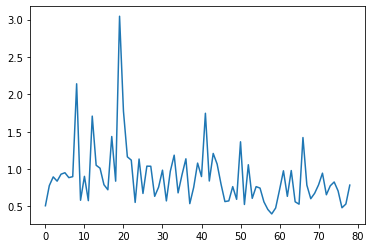

In [322]:
plt.plot(fold_results)

In [329]:
# y_val1 = y_scaler.transform(y_val)
# y_val['log_return'] = y_val1
y_val['y_pred'] = y_pred
y_val.sort_values('y_pred')

log_return    y_pred
date       sector                      
2023-07-21 超清视频     -0.747724 -0.006498
           无线充电     -0.590213 -0.006498
           鸿蒙概念     -0.533444 -0.006498
           参股期货      0.906511 -0.006498
           华为汽车     -0.639157 -0.006498
...                       ...       ...
           超级品牌      1.139665  0.012763
           电商概念      0.684742  0.012763
           退税商店      0.428881  0.012763
           上证180_    0.478583  0.012763
           肝素概念      0.537739  0.013300

[495 rows x 2 columns]

In [337]:
y_val['log_return'].sort_values()

date        sector
2023-07-21  虚拟电厂     -0.072728
            减速器      -0.070675
            光通信模块    -0.070107
            机器人执行器   -0.069354
            F5G概念    -0.068351
                        ...   
            医废处理      0.089352
            新型城镇化     0.100380
            地下管网      0.110924
            山西板块      0.134471
            重组蛋白      0.164907
Name: log_return, Length: 495, dtype: float64

In [ ]:

# Convert 'date' column to datetime if not already
data['date'] = pd.to_datetime(data['date'])

# Sort the data by 'sector' and 'date'
data.sort_values(by=['sector', 'date'], inplace=True)

# Define features and target
features = ['open_lag_1', 'close_lag_1', 'volume_lag_1', 'turnover_lag_1', 'outstanding_lag_1', 'high_lag_1', 'low_lag_1', 
            'open_ma_5', 'close_ma_5', 'volume_ma_5', 'turnover_ma_5', 'outstanding_ma_5', 'high_ma_5', 'low_ma_5', 
            'price_change', 'log_return_lag_1', 'return_vs_lag', 'return_vs_ma_5', 'return_vs_ma_10']

target = 'log_return'

# Initialize an array to store evaluation results
eval_results = []

# Group data by sector
grouped = data.groupby('sector')

# Loop through each sector
for sector, sector_data in grouped:
    X = sector_data[features]
    y = sector_data[target]
    
    # Initialize LightGBM model
    model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1)
    
    # Initialize lists to store fold results
    fold_results = []
    
    # Perform rolling time series cross-validation
    for i in range(1, len(X) - 1):
        X_train, X_val = X[:i], X[i:i+1]
        y_train, y_val = y[:i], y[i:i+1]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on validation data
        y_pred = model.predict(X_val)
        
        # Evaluate the model
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        fold_results.append(rmse)
    
    eval_results.append((sector, fold_results))

In [ ]:
for sector, fold_results in eval_results:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(X)-1), fold_results, marker='o')
    plt.title(f'Sector {sector} - Rolling Time Series Cross-Validation',fontproperties=fontP)
    plt.xlabel('Fold')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()

In [170]:
importances = model.feature_importances_

# Create a DataFrame to hold feature names and importances
importance_df = pd.DataFrame({'Feature': range(4), 'Importance': importances})
importance_df

Feature  Importance
0        0         700
1        1         400
2        2         800
3        3        1100